### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

**Collab setting**

In [1]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2019-05-15 13:08:23--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2019-05-15 13:08:23 (31.6 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [2]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
! pip install pandas sklearn

    100% |████████████████████████████████| 6.7MB 6.1MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 44.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [8]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [9]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


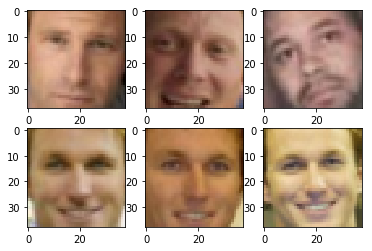

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [11]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [12]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32, n=38):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Linear(n, code_size)
        self.dec = nn.Linear(code_size , n)
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [13]:
def train(model, dataset, num_epoch=32):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            loss = model.batch_loss(batch.to(device))
            (loss).backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [14]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].to(device))
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [11]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, 40)

#1, Train loss: 0.0231211
#2, Train loss: 0.0146911
#3, Train loss: 0.0110448
#4, Train loss: 0.0088870
#5, Train loss: 0.0074370
#6, Train loss: 0.0063927
#7, Train loss: 0.0056029
#8, Train loss: 0.0049818
#9, Train loss: 0.0044788
#10, Train loss: 0.0040640
#11, Train loss: 0.0037176
#12, Train loss: 0.0034246
#13, Train loss: 0.0031735
#14, Train loss: 0.0029559
#15, Train loss: 0.0027657
#16, Train loss: 0.0025981
#17, Train loss: 0.0024492
#18, Train loss: 0.0023163
#19, Train loss: 0.0021969
#20, Train loss: 0.0020892
#21, Train loss: 0.0019916
#22, Train loss: 0.0019027
#23, Train loss: 0.0018214
#24, Train loss: 0.0017467
#25, Train loss: 0.0016780
#26, Train loss: 0.0016144
#27, Train loss: 0.0015555
#28, Train loss: 0.0015008
#29, Train loss: 0.0014498
#30, Train loss: 0.0014022
#31, Train loss: 0.0013577
#32, Train loss: 0.0013159
#33, Train loss: 0.0012766
#34, Train loss: 0.0012396
#35, Train loss: 0.0012047
#36, Train loss: 0.0011718
#37, Train loss: 0.0011406
#38, Train

In [12]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.to(device)).data.cpu().numpy())
print (np.mean(scores))

1.8104960318071667e-05


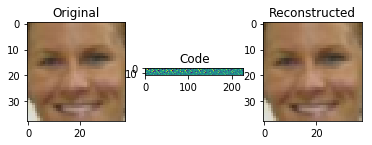

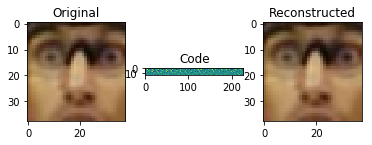

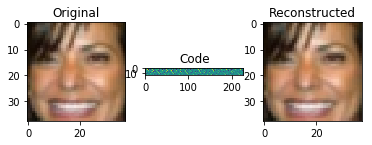

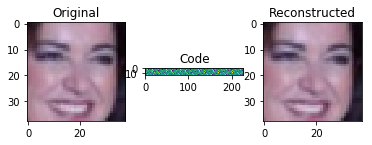

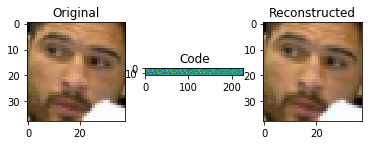

In [13]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are good idea. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [14]:
#from google.colab import drive
#drive.mount('/gdrive')

In [15]:
#! ls /gdrive

In [15]:
! wget https://gist.githubusercontent.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5/raw/d837f5c96a727d1b3292a3eedf06c19aca6c1a8a/weight_init.py

--2019-05-15 13:13:42--  https://gist.githubusercontent.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5/raw/d837f5c96a727d1b3292a3eedf06c19aca6c1a8a/weight_init.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2511 (2.5K) [text/plain]
Saving to: ‘weight_init.py’

weight_init.py      100%[===================>]   2.45K  --.-KB/s    in 0s      

2019-05-15 13:13:43 (51.0 MB/s) - ‘weight_init.py’ saved [2511/2511]



In [17]:
! pip install tqdm

    100% |████████████████████████████████| 51kB 3.4MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
import itertools
import collections
import copy
import contextlib
import tqdm
import math
import numpy as np

from weight_init import weight_init

        
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


@contextlib.contextmanager
def fork_torch_model(model):
    initial_state = copy.deepcopy(model.state_dict())
    try:
        yield
    finally:
        model.load_state_dict(initial_state)
        model.to(DEVICE)


class StagedTraining:
    def __init__(self, model, trainset, testset, epoch_iter_wrapper=tqdm.tqdm, summary_every=25):
        self.summary_every = summary_every
        self.model = model
        self.dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
        self.test_loader = DataLoader(testset, batch_size=BATCH_SIZE)
        self.epoch = 0
        self.set_adaptive(optim.Adam, dict(betas=(.75, .99), lr=.003))
        self.epoch_iter_wrapper = epoch_iter_wrapper
    def set_adaptive(self, adaptive_cls, adaptive_kwargs: dict):
        self.instr_adaptive = adaptive_cls, copy.deepcopy(adaptive_kwargs)
        return self
    def random_init(self):
        self.model.apply(weight_init)
    @staticmethod
    def generic_step(model, optimizer, batch):
        model.train()
        optimizer.zero_grad()
        batch = batch.double().to(DEVICE)
        loss = model.batch_loss(batch)
        loss.backward()
        optimizer.step()
        return loss.item()
    def make_epochs(self, n_epochs: int):
        epochs = self._make_epochs(n_epochs)
        if self.epoch_iter_wrapper is not None:
            epochs = self.epoch_iter_wrapper(epochs)
        return epochs
    def _make_epochs(self, n_epochs: int):
        epoch0 = self.epoch
        epochs_end = self.epoch + n_epochs
        for e in range(epoch0, epochs_end):
            self.epoch = e
            yield e
            if (e + 1) % self.summary_every == 0:
                torch.save(self.model.state_dict(), f'aenc_{e}.pth')
                print('[{:04}/{:04}] Reconstruction MSE: {:.5f}'.format(e, epochs_end, self.evaluate()))
        self.epoch = epochs_end
    def train_adaptive(self, n_epochs: int, **kwargs):
        adaptive_cls, adaptive_kwargs = self.instr_adaptive
        adaptive_kwargs = collections.ChainMap(kwargs, adaptive_kwargs)
        opt = adaptive_cls(self.model.parameters(), **adaptive_kwargs)
        for e in self.make_epochs(n_epochs):
            for x in self.dataloader:
                self.generic_step(self.model, opt, x)
    def sylvain_gugger_table(self,
                             lr_min: float = 1e-9,
                             lr_max: float = 5,
                             num: int = 100,
                             iters_per_lr: int = 1):
        factor = (lr_max/lr_min)**(1/(num - 1))
        #test_lr = itertools.takewhile(
        #    lambda lr: lr < lr_max,
        #    (1.0 * lr_min * factor**k for k in itertools.count()),
        #)
        test_lr = [1.0 * lr_min * factor**k for k in range(num)]
        test_lr = np.array(list(test_lr))
        lr_loss = np.zeros_like(test_lr)
        model = self.model
        batches = itertools.cycle(self.dataloader)
        batch_lr = (itertools.repeat(x, iters_per_lr) for x in enumerate(test_lr))
        batch_lr = itertools.chain.from_iterable(batch_lr)
        data = zip(batch_lr, batches)
        losses = collections.defaultdict(list)
        with fork_torch_model(model):
            opt = optim.SGD(model.parameters(), lr=.001)
            for (i, lr), x in data:
                for param_group in opt.param_groups:
                    param_group['lr'] = lr
                self.generic_step(model, opt, x)
                with torch.no_grad():
                    losses[i].append(model.batch_loss(x.double().to(DEVICE)).item())
        for i in losses.keys():
            lr_loss[i] = np.mean(losses[i])
        return test_lr, lr_loss
    @staticmethod
    def sylvain_gugger_lr(test_lr, lr_loss):
        i = np.nanargmin(lr_loss)
        return test_lr[i]
    def sylvain_gugger_find_lr(self, init_value = 1e-8, final_value=10., beta = 0.98):
        # added
        net = self.model
        optimizer = optim.SGD(net.parameters(), lr=init_value)
        trn_loader = self.dataloader
        loss_history = []
        smooth_history = []
        # end added
        num = len(trn_loader)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in trn_loader:
            batch_num += 1
            #As before, get the loss for this mini-batch of inputs/outputs
            
            # modified loss computation
            data = data.double().to(DEVICE)
            
            optimizer.zero_grad()
            loss = net.batch_loss(data)
            #Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) * loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)
            
            # added
            loss_history.append(loss.item())
            smooth_history.append(smoothed_loss)
            # end added
            
            #Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            #Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss
            #Store the values
            losses.append(smoothed_loss)
            log_lrs.append(math.log10(lr))
            #Do the SGD step
            loss.backward()
            optimizer.step()
            #Update the lr for the next step
            lr *= mult
            optimizer.param_groups[0]['lr'] = lr
        # modified return statement
        return optimizer.param_groups[0]['lr'], log_lrs, loss_history, smooth_history

    def train_sgd(self, n_epochs: int, lr: float):
        opt = optim.SGD(self.model.parameters(), lr=lr)
        for e in self.make_epochs(n_epochs):
            for x in self.dataloader:
                self.generic_step(self.model, opt, x)
    def evaluate(self):
        model = self.model
        model.eval()
        with torch.no_grad():
            scores = []
            for i, batch in enumerate(self.test_loader):
                scores.append(model.batch_loss(batch.double().to(DEVICE)).data.cpu().numpy())
                # encoder_out = model.enc(batch.to(DEVICE))
            reconstruction_mse  = np.mean(scores)
            return reconstruction_mse

In [110]:
import collections


class BatchReshape(nn.Module):
    def __init__(self, *output_size):
        super(BatchReshape, self).__init__()
        self.output_size = output_size
    def forward(self, input):
        return torch.reshape(input, (input.shape[0],) + self.output_size)

class Interpolate(nn.Module):
    def __init__(self, *output_size):
        super(Interpolate, self).__init__()
        self.output_size = output_size
    def forward(self, input):
        return nn.functional.interpolate(input, size=self.output_size)

class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32, n=38, end_channels=10):
        super(pca_autoencoder_deep, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=5, padding=2),
            # nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.Conv2d(100, 75, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(75, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(25, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, end_channels, kernel_size=5, padding=2),
            # nn.BatchNorm2d(end_channels),
            nn.ReLU(),
            BatchReshape(end_channels*n*n),
            # nn.BatchNorm1d(end_channels*n*n),
            nn.ReLU(),
            nn.Linear(end_channels*n*n, code_size),
            nn.Tanh(),
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, end_channels*n*n),
            BatchReshape(end_channels, n, n),
            nn.ReLU(),
            nn.ConvTranspose2d(end_channels, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(25, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 3, kernel_size=5, padding=2),
        )
        self.apply(weight_init)
    def batch_loss(self, batch):
        enc = self.enc(batch)
        reconstruction = self.dec(enc)
        return torch.mean((batch - reconstruction)**2)

In [111]:
#aenc_deep = pca_autoencoder_deep()
#aenc_deep.load_state_dict(torch.load('/gdrive/My Drive/aenc_deep_state4.pth'))
#aenc_deep = aenc_deep.to(torch.double).to(torch.device('cuda'))

#aenc_deep = pca_autoencoder_deep(end_channels=25)
#train(aenc_deep, X_train_tensor, num_epoch=50, cons_optimizer=lambda parameters: optim.Adam(parameters, betas=(.5, .99), lr=.005))
#torch.save(aenc_deep.state_dict(), 'aenc_deep_state6.pth')

In [112]:
import scipy as sp
import scipy.signal

In [116]:
torch.manual_seed(666)


model = pca_autoencoder_deep(end_channels=5).to(DEVICE).to(torch.double)

In [117]:
trainer = StagedTraining(model, X_train_tensor, X_test_tensor)

In [ ]:
ADA_EPOCHS = 40


trainer.random_init()
print('Reconstruction MSE after random init: {:.5f}'.format(trainer.evaluate()))
print('Entering first phase with Adam')
trainer.train_adaptive(n_epochs=ADA_EPOCHS)
print('Evaluating')
print('Reconstruction MSE after {} adaptive epochs: {:.5f}'.format(ADA_EPOCHS, trainer.evaluate()))















0it [00:00, ?it/s]

Reconstruction MSE after random init: 2.13449
Entering first phase with Adam
















1it [00:08,  8.57s/it]













2it [00:17,  8.56s/it]













3it [00:25,  8.57s/it]













4it [00:34,  8.57s/it]













5it [00:42,  8.57s/it]













6it [00:51,  8.57s/it]













7it [01:00,  8.58s/it]













8it [01:08,  8.59s/it]













9it [01:17,  8.59s/it]













10it [01:25,  8.59s/it]













11it [01:34,  8.58s/it]













12it [01:42,  8.57s/it]













13it [01:51,  8.55s/it]













14it [01:59,  8.54s/it]













15it [02:08,  8.53s/it]













16it [02:16,  8.53s/it]













17it [02:25,  8.54s/it]













18it [02:34,  8.55s/it]













19it [02:42,  8.57s/it]

In [102]:
def try_sgd(sgd_epochs, min_lr=1e-12, max_lr=1e-2, num_rates=200):
    test_lr, lr_loss = trainer.sylvain_gugger_table(min_lr, max_lr, num_rates, iters_per_lr=1)
    MAX_LOSS = .05
    _valid_loss = (~np.isnan(lr_loss)) & (lr_loss < MAX_LOSS)
    test_lr, lr_loss = test_lr[_valid_loss], lr_loss[_valid_loss]
    lr_loss_smooth = sp.signal.savgol_filter(lr_loss, 21, 2)
    best_lr = trainer.sylvain_gugger_lr(test_lr, lr_loss_smooth)
    fig, ax = plt.subplots()
    ax.set_title('SGD lr versus loss as per Sylvain Gugger')
    ax.set_xlabel('Log LR')
    ax.set_ylabel('Loss')
    ax.set_xscale('log')
    ax.plot(test_lr, lr_loss, color='gray', linestyle='--')
    ax.plot(test_lr, lr_loss_smooth, color='red')
    ax.axvline(x=best_lr, color='black', linestyle='--')
    plt.show()
    print('Picking lr={:.5f}'.format(best_lr))
    trainer.train_sgd(sgd_epochs, lr=best_lr)
    print('Reconstruction MSE after {} SGD epochs: {:.5f}'.format(sgd_epochs, trainer.evaluate()))
def try_copypasted_find_lr(sgd_epochs, min_lr=1e-12, max_lr=1e-2, beta=.98):
    best_lr, log_lr, lr_loss, lr_loss_smooth = trainer.sylvain_gugger_find_lr(init_value = min_lr, final_value=max_lr, beta=beta)
    test_lr = np.exp(log_lr)
    fig, ax = plt.subplots()
    ax.set_title('SGD lr versus loss as per Sylvain Gugger')
    ax.set_xlabel('Log LR')
    ax.set_ylabel('Loss')
    ax.set_xscale('log')
    ax.plot(test_lr, lr_loss, color='gray', linestyle=':')
    ax.plot(test_lr, lr_loss_smooth, color='red')
    ax.axvline(x=best_lr, color='black', linestyle='--')
    plt.show()
    print('Picking lr={:.5e}'.format(best_lr))
    trainer.train_sgd(sgd_epochs, lr=best_lr)
    print('Reconstruction MSE after {} SGD epochs: {:.5f}'.format(sgd_epochs, trainer.evaluate()))
    

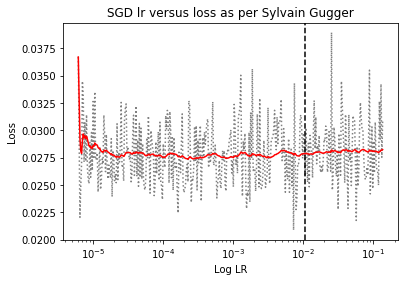














0it [00:00, ?it/s]

Picking lr=1.06439e-02















1it [00:05,  5.41s/it]












2it [00:10,  5.41s/it]












3it [00:16,  5.41s/it]












4it [00:21,  5.42s/it]












5it [00:27,  5.42s/it]

[0024/0120] Reconstruction MSE: 0.02765















6it [00:32,  5.51s/it]












7it [00:38,  5.51s/it]












8it [00:43,  5.51s/it]












9it [00:49,  5.52s/it]












10it [00:54,  5.50s/it]












11it [01:00,  5.48s/it]












12it [01:05,  5.45s/it]












13it [01:11,  5.45s/it]












14it [01:16,  5.44s/it]












15it [01:21,  5.44s/it]












16it [01:27,  5.44s/it]












17it [01:32,  5.44s/it]












18it [01:38,  5.43s/it]












19it [01:43,  5.44s/it]












20it [01:49,  5.44s/it]












21it [01:54,  5.45s/it]












22it [02:00,  5.43s/it]












23it [02:05,  5.43s/it]












24it [02:10,  5.44s/it]












25it [02:16,  5.44s/it]












26it [02:21,  5.44s/it]












27it [02:27,  5.44s/it]












28it [02:32,  5.44s/it]












29it [02:38,  5.44s/it]












30it [02:43,  5.44s/it]

[0049/0120] Reconstruction MSE: 0.02756















31it [02:49,  5.53s/it]












32it [02:54,  5.51s/it]

KeyboardInterrupt: 

In [109]:
try_copypasted_find_lr(100)
torch.save(model.state_dict(), 'aenc_after_sgd.pth')

Training may take long, it's okay.

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [ ]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size).to(device)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor').to(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]), f"encoder output size, expected {code_size} got {encoder_out.shape[1:]}"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (len(list(model.dec.children())) >= 6),  "decoder must contain at least 3 dense layers"

print("All tests passed!")

__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

** Lets check you model's score. You should beat value of 0.005 **

In [ ]:
aenc_deep = model
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.to(device)).data.cpu().numpy())
    # encoder_out = aenc_deep.enc(batch.to(device))
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.005, f"Compression is too lossy, mse={reconstruction_mse:.5f}, expected no more than .005. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular ones: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
        
    noise = np.random.randn(*X.shape)*sigma
    return X + noise
    

**noise tests**

In [ ]:

theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, (
    f"Standard deviation ({our_std:.5f}) does not match it's required value ({theoretical_std:.5f})."
    " Make sure you use sigma as std."
)
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
def train_noise(model, dataset, num_epoch=50, sigma=0.1, lr=0.002):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            batch = batch.to(device)
            orig = torch.clone(batch)
            apply_gaussian_noise(batch, sigma)
            gd.zero_grad()
            recons = model.dec(model.enc(batch))
            loss = torch.sum((orig - recons)**2)
            loss.backward()
            losses.append(loss.item())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [ ]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

In [ ]:
X_train_tensor_n = torch.from_numpy(X_train_noise).type(torch.DoubleTensor)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [ ]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor_n, 50)

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

** Let's evaluate!!! **

In [ ]:
dataloader_test = DataLoader(X_test_tensor_n, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.to(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor_n[i]
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
#encodes batch of images into a codes


with torch.no_grad():
    codes = aenc_deep.enc(X_train)

In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = #<Your code: using lshf.kneighbors find nearest neighbors>
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test_tensor[2])

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

In [ ]:
#glasses
show_similar(X_test_tensor[66])

## Cheap image morphing


Here you should take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

In [ ]:

for _ in range(5):
    image1,image2 =#<Your code:choose two image randomly>

    code1, code2 = #<Your code:decode it>


    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = #<Your code:define intermixture code>

        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.